In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import LogRegAC.logRegAC as logRegAC
import LogRegAC.utilsAC as utilsAC
import LogRegAC.crossValdAC as crossValdAC

In [2]:
data = pd.read_csv('data.csv', header=None)
print(data.shape)
data.head()

(200, 3)


,0,1,2
0,6,32,1
1,26,39,1
2,2,38,1
3,25,39,1
4,3,35,1


In [3]:
data = data.sample(frac=1).reset_index(drop=True)
data_x = data.iloc[:, 0:-1]
data_y = data.iloc[:, -1].replace(-1, 0)

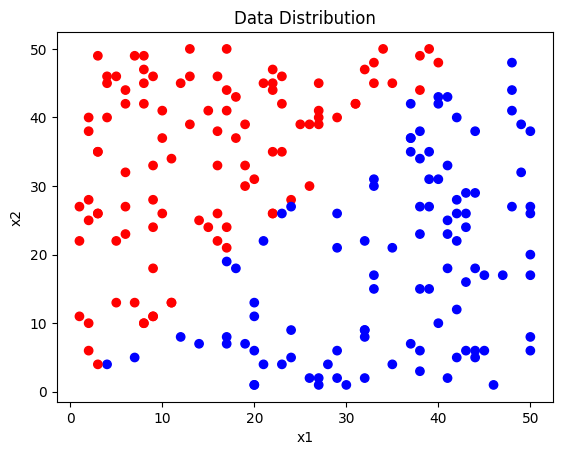

In [4]:
fig = plt.figure()
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Data Distribution')
plt.show()
fig.savefig('plots/data_dist.png')

In [5]:
train_x, train_y, test_x, test_y = utilsAC.splitTrainTest(data_x, data_y, 0.8)
train_x, train_min, train_max = utilsAC.normMinMax(train_x, mode='train')
test_x = utilsAC.normMinMax(test_x, mode='test', train_min=train_min, train_max=train_max)

thresh = np.arange(0, 1, 0.001)

## Newton's Method

In [6]:
nwt = logRegAC.LogReg(max_iter=100, eps=1e-5, newton=True)
t_beta = nwt.fit(train_x, train_y, iter_step=10, reg_term=1)
nwt_pred = nwt.predict(test_x)
print('F1 Score: ', utilsAC.get_performance_measure(test_y, nwt_pred)['f1'])

Implementing Newton's Method.
Iteration     0 | Cost:  169.430
Iteration    10 | Cost:  15.330
Iteration    20 | Cost:  11.333
Iteration    30 | Cost:  9.764
Iteration    40 | Cost:  8.860
Iteration    50 | Cost:  8.252
Iteration    60 | Cost:  7.804
Iteration    70 | Cost:  7.455
Iteration    80 | Cost:  7.173
Iteration    90 | Cost:  6.937
Iteration   100 | Cost:  6.737
F1 Score:  0.888888888888889


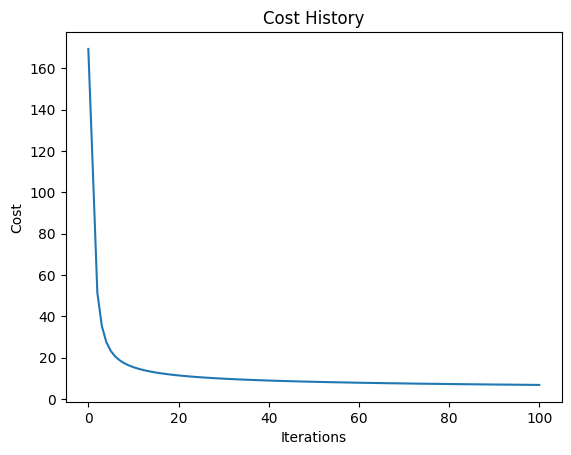

In [7]:
fig = plt.figure()
plt.plot(nwt.get_cost_hist())
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost History')
plt.show()
fig.savefig('plots/nwt_cost_hist.png')

In [8]:
nwt_trained_weights = nwt.get_params()
print(f'Trained Weights: {nwt_trained_weights}')
nwt_cf_info = utilsAC.get_performance_measure(data_y, nwt.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
nwt_cf_matrix = [[nwt_cf_info['tn'], nwt_cf_info['fn']], [nwt_cf_info['fp'], nwt_cf_info['tp']]]

Trained Weights: [[  1.49909157]
 [-31.67325538]
 [ 26.18054355]]


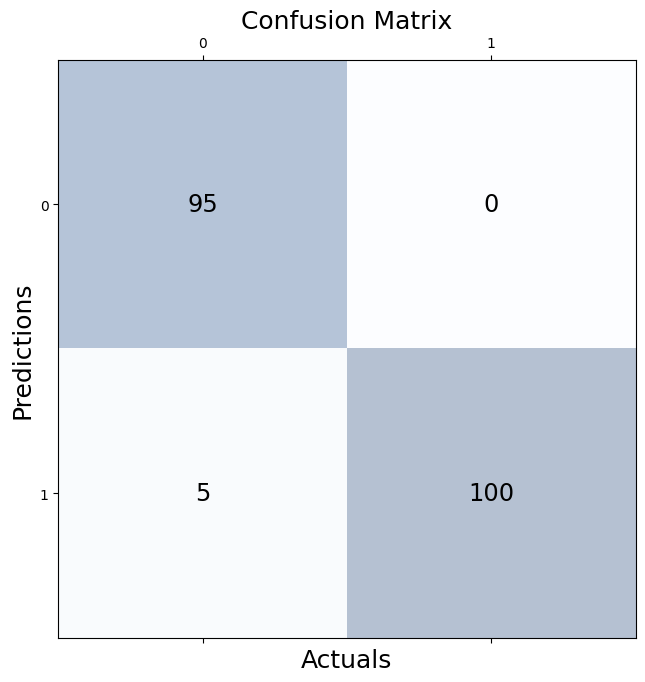

In [9]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(nwt_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(nwt_cf_matrix)):
    for j in range(len(nwt_cf_matrix[i])):
        ax.text(x=j, y=i,s=nwt_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/nwt_confusion_matrix.png')

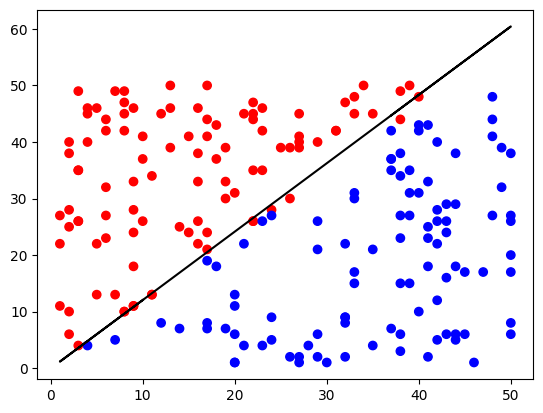

In [10]:
nwt_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], nwt_trained_weights).flatten()
nwt_plot_y = []
for i in range(len(nwt_vals)):
    nwt_plot_y.append(-(nwt_trained_weights[0] + (nwt_trained_weights[1] * data_x.iloc[i, 0])) / nwt_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], nwt_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/nwt_data_dist_db.png')

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/logRegAC.py:96: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


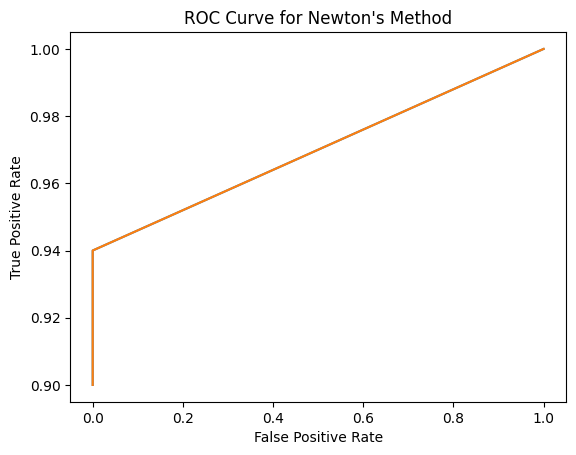

In [11]:
nwt_pred_prob = nwt.predict(data_x, prob=True)
nwt_tpr = []
nwt_fpr = []
for t in thresh:
    nwt_pred = [1 if i >= t else 0 for i in nwt_pred_prob]
    nwt_cf_info = utilsAC.get_performance_measure(data_y, nwt_pred)
    tp = nwt_cf_info['tp']
    fp = nwt_cf_info['fp']
    tn = nwt_cf_info['tn']
    fn = nwt_cf_info['fn']
    nwt_tpr.append(tp/(tp+fn))
    nwt_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(nwt_fpr, nwt_tpr)
plt.plot(nwt_fpr, nwt_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Newton\'s Method')
plt.show()
fig.savefig('plots/nwt_roc.png')

## Using cross-validation Techniques

In [12]:
lrs = [0.01, 0.005, 0.003, 0.001]
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'violet', 'purple']

### Holdout Method with Batch Gradient Descent

In [13]:
hld_cv = crossValdAC.CrossVald(option='holdout')
gd_hld_train_costs, gd_hld_opt_model = hld_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5)

Implementing Holdout Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  31.785
Iteration   200 | Cost:  24.589
Iteration   300 | Cost:  21.293
Iteration   400 | Cost:  19.274
Iteration   500 | Cost:  17.864
Iteration   600 | Cost:  16.803
Iteration   700 | Cost:  15.964
Iteration   800 | Cost:  15.278
Iteration   900 | Cost:  14.702
Iteration  1000 | Cost:  14.210
F1-score: 0.967741935483871
----------------- lr : 0.005 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  43.362
Iteration   200 | Cost:  33.435
Iteration   300 | Cost:  28.904
Iteration   400 | Cost:  26.172
Iteration   500 | Cost:  24.287
Iteration   600 | Cost:  22.883
Iteration   700 | Cost:  21.780
Iteration   800 | Cost:  20.883
Iteration   900 | Cost:  20.133
Iteration  1000 | Cost:  19.493
F1-score: 0.9795918367346939
----------------- lr : 0.003 ----

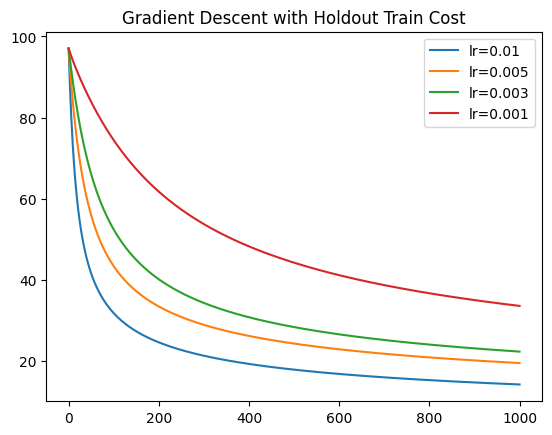

In [14]:
fig = plt.figure()
for i in range(len(gd_hld_train_costs)):
    plt.plot(gd_hld_train_costs[i], label=f'lr={lrs[i]}')
plt.legend()
plt.title('Gradient Descent with Holdout Train Cost')
plt.show()
fig.savefig('plots/gd_hld.png')

In [15]:
print(gd_hld_opt_model)

{'f1': 0.9818181818181818, 'lr': 0.003, 'w': array([[ 0.74767953],
       [-9.28781345],
       [ 6.986473  ]])}


In [16]:
best_hld_gd = logRegAC.LogReg()
best_hld_gd.set_params(gd_hld_opt_model['w'])
hld_gd_cf_info = utilsAC.get_performance_measure(data_y, best_hld_gd.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
hld_gd_cf_matrix = [[hld_gd_cf_info['tn'], hld_gd_cf_info['fn']], [hld_gd_cf_info['fp'], hld_gd_cf_info['tp']]]

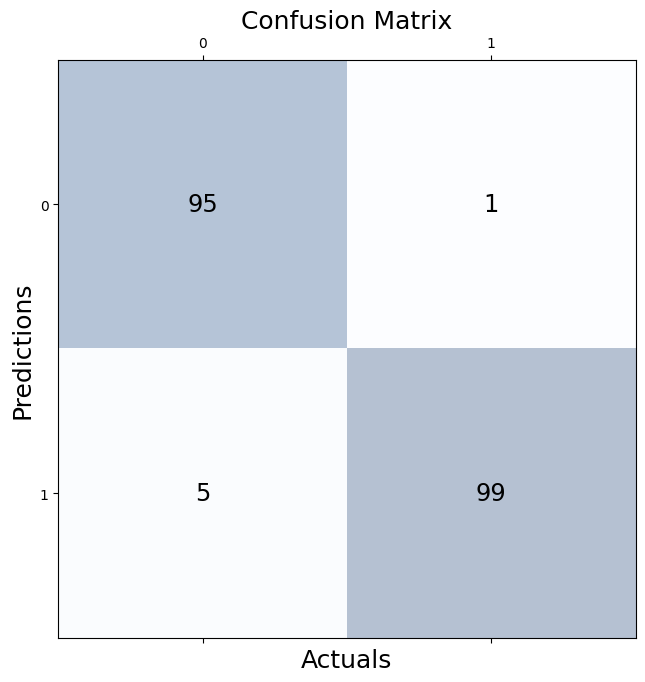

In [17]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(hld_gd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(hld_gd_cf_matrix)):
    for j in range(len(hld_gd_cf_matrix[i])):
        ax.text(x=j, y=i,s=hld_gd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/hld_gd_confusion_matrix.png')

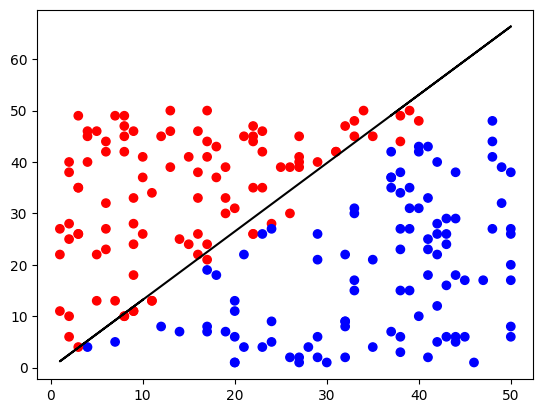

In [18]:
hld_gd_trained_weights = gd_hld_opt_model['w']
hld_gd_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], hld_gd_trained_weights).flatten()
gd_plot_y = []
for i in range(len(hld_gd_vals)):
    gd_plot_y.append(-(hld_gd_trained_weights[0] + (hld_gd_trained_weights[1] * data_x.iloc[i, 0])) / hld_gd_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], gd_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/hld_gd_data_dist_db.png')

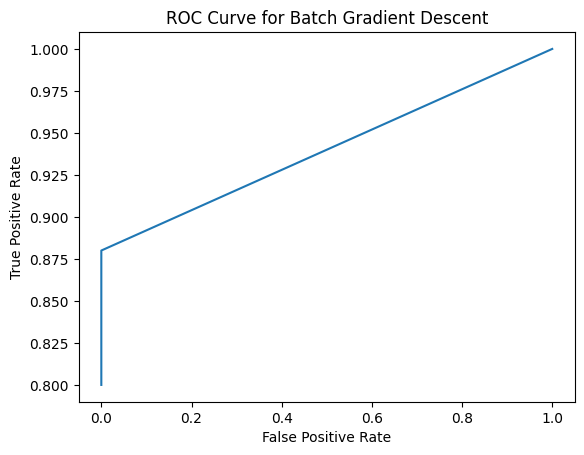

In [19]:
hld_gd_pred_prob = best_hld_gd.predict(data_x, prob=True)
gd_tpr = []
gd_fpr = []
for t in thresh:
    gd_pred = [1 if i >= t else 0 for i in hld_gd_pred_prob]
    gd_cf_info = utilsAC.get_performance_measure(data_y, gd_pred)
    tp = gd_cf_info['tp']
    fp = gd_cf_info['fp']
    tn = gd_cf_info['tn']
    fn = gd_cf_info['fn']
    gd_tpr.append(tp/(tp+fn))
    gd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(gd_fpr, gd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Batch Gradient Descent')
plt.show()
fig.savefig('plots/hld_gd_roc.png')

### Holdout Method with Stochastic Gradient Descent

In [20]:
sgd_hld_train_costs, sgd_hld_opt_model = hld_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5, stochGD=True)

Implementing Holdout Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  31.462
Iteration   200 | Cost:  24.434
Iteration   300 | Cost:  21.328
Iteration   400 | Cost:  19.460
Iteration   500 | Cost:  18.168
Iteration   600 | Cost:  17.201
Iteration   700 | Cost:  16.437
Iteration   800 | Cost:  15.813
Iteration   900 | Cost:  15.288
Iteration  1000 | Cost:  14.839
F1-score: 0.967741935483871
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  42.866
Iteration   200 | Cost:  32.592
Iteration   300 | Cost:  27.912
Iteration   400 | Cost:  25.100
Iteration   500 | Cost:  23.169
Iteration   600 | Cost:  21.734
Iteration   700 | Cost:  20.611
Iteration   800 | Cost:  19.699
Iteration   900 | Cost:  18.939
Iteration  1000 | Cost:  18.292
F1-score: 0.9523809523809523
----------------- lr : 

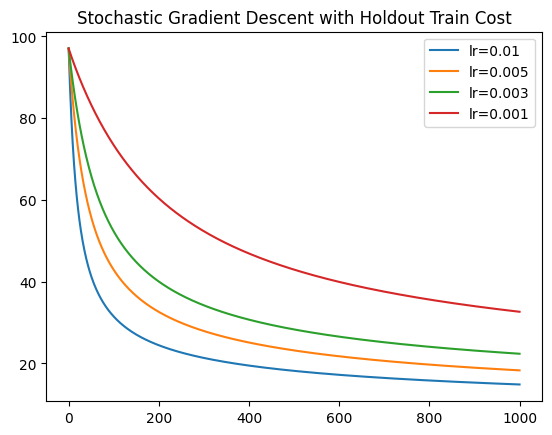

In [21]:
fig = plt.figure()
for i in range(len(sgd_hld_train_costs)):
    plt.plot(sgd_hld_train_costs[i], label=f'lr={lrs[i]}')
plt.legend()
plt.title('Stochastic Gradient Descent with Holdout Train Cost')
plt.show()
fig.savefig('plots/sgd_hld.png')

In [22]:
print(sgd_hld_opt_model)

{'f1': 1.0, 'lr': 0.003, 'w': array([[ 0.46043606],
       [-8.94216607],
       [ 7.38735874]])}


In [23]:
best_hld_sgd = logRegAC.LogReg()
best_hld_sgd.set_params(sgd_hld_opt_model['w'])
hld_sgd_cf_info = utilsAC.get_performance_measure(data_y, best_hld_sgd.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
hld_sgd_cf_matrix = [[hld_sgd_cf_info['tn'], hld_sgd_cf_info['fn']], [hld_sgd_cf_info['fp'], hld_sgd_cf_info['tp']]]

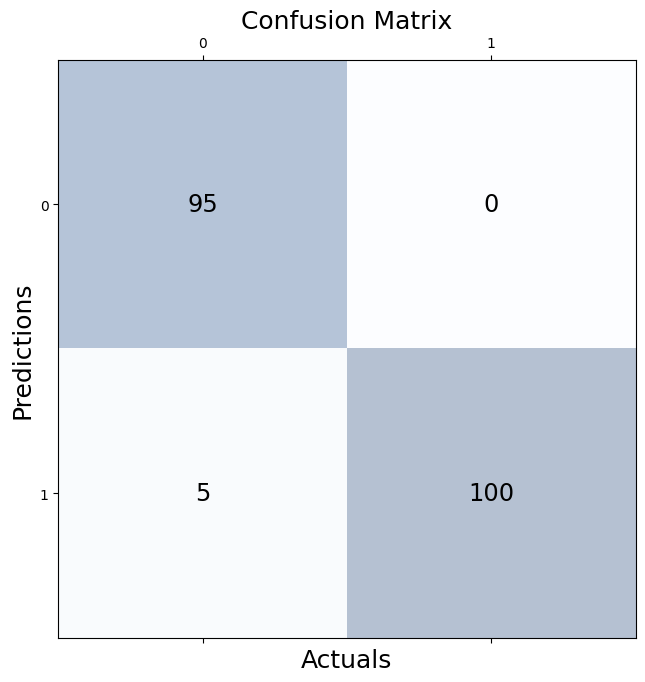

In [24]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(hld_sgd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(hld_sgd_cf_matrix)):
    for j in range(len(hld_sgd_cf_matrix[i])):
        ax.text(x=j, y=i,s=hld_sgd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/hld_sgd_confusion_matrix.png')

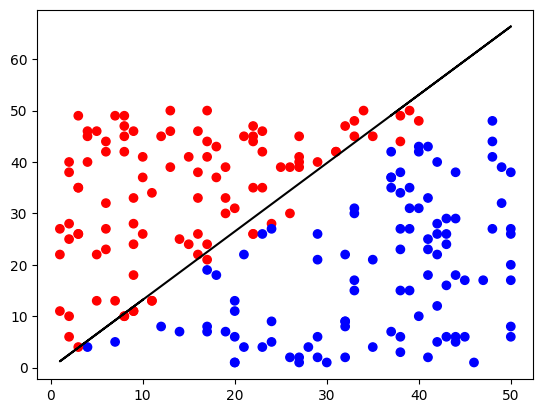

In [25]:
hld_sgd_trained_weights = sgd_hld_opt_model['w']
hld_sgd_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], hld_sgd_trained_weights).flatten()
sgd_plot_y = []
for i in range(len(hld_gd_vals)):
    sgd_plot_y.append(-(hld_sgd_trained_weights[0] + (hld_sgd_trained_weights[1] * data_x.iloc[i, 0])) / hld_sgd_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], gd_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/hld_sgd_data_dist_db.png')

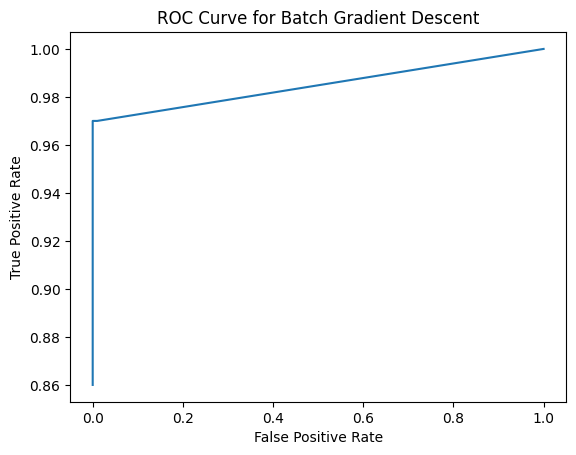

In [26]:
hld_sgd_pred_prob = best_hld_sgd.predict(data_x, prob=True)
sgd_tpr = []
sgd_fpr = []
for t in thresh:
    sgd_pred = [1 if i >= t else 0 for i in hld_sgd_pred_prob]
    sgd_cf_info = utilsAC.get_performance_measure(data_y, sgd_pred)
    tp = sgd_cf_info['tp']
    fp = sgd_cf_info['fp']
    tn = sgd_cf_info['tn']
    fn = sgd_cf_info['fn']
    sgd_tpr.append(tp/(tp+fn))
    sgd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(sgd_fpr, sgd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Batch Gradient Descent')
plt.show()
fig.savefig('plots/hld_sgd_roc.png')

### Monte Carlo Cross-Validation with Batch Gradient Descent

In [27]:
montc_cv = crossValdAC.CrossVald(option='monte_carlo', monte_carlo=5)
gd_montc_train_costs, gd_montc_opt_model = montc_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5)

Implementing Monte Carlo Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  31.457
Iteration   200 | Cost:  24.381
Iteration   300 | Cost:  21.209
Iteration   400 | Cost:  19.292
Iteration   500 | Cost:  17.964
Iteration   600 | Cost:  16.971
Iteration   700 | Cost:  16.189
Iteration   800 | Cost:  15.551
Iteration   900 | Cost:  15.017
Iteration  1000 | Cost:  14.561
F1-score: 0.9722222222222222
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  32.007
Iteration   200 | Cost:  24.446
Iteration   300 | Cost:  21.079
Iteration   400 | Cost:  19.065
Iteration   500 | Cost:  17.685
Iteration   600 | Cost:  16.662
Iteration   700 | Cost:  15.864
Iteration   800 | Cost:  15.219
Iteration   900 | Cost:  14.682
Iteration  1000 | Cost:  14.227
F1-score: 0.9666666666666666
----------------- lr : 0.01 -

In [28]:
print(gd_montc_opt_model)

{'f1': 0.9776023391812864, 'lr': 0.01, 'w': array([[  0.76559062],
       [-14.4057097 ],
       [ 11.51688563]])}


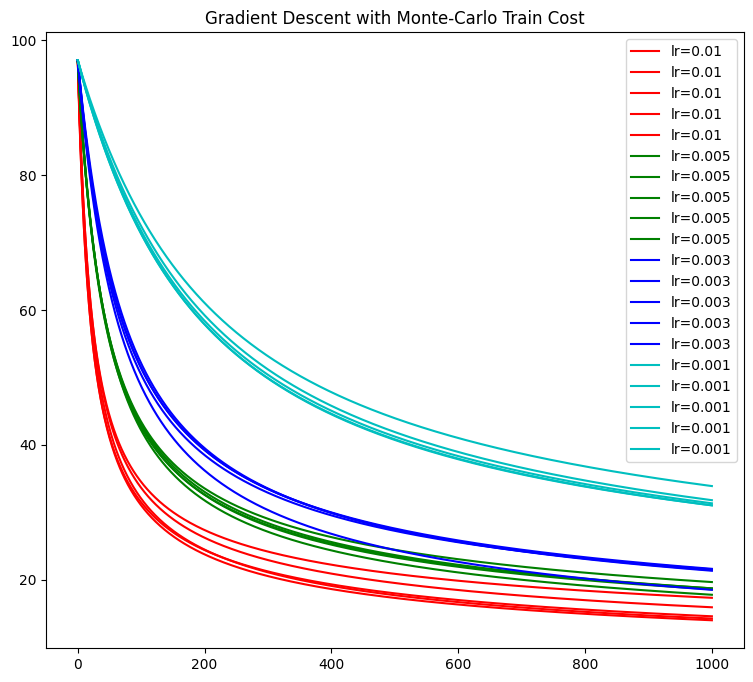

In [29]:
fig = plt.figure(figsize=(9, 8))
for i in range(len(gd_montc_train_costs)):
    for j in range(len(gd_montc_train_costs[i])):
        plt.plot(gd_montc_train_costs[i][j], label=f'lr={lrs[i]}', color=colors[i])
plt.legend()
plt.title('Gradient Descent with Monte-Carlo Train Cost')
plt.show()
fig.savefig('plots/gd_montc.png')

### Monte Carlo Cross-Validation with Stochastic Gradient Descent

In [30]:
sgd_montc_train_costs, sgd_montc_opt_model = montc_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5, stochGD=True)

Implementing Monte Carlo Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  30.228
Iteration   200 | Cost:  22.889
Iteration   300 | Cost:  19.676
Iteration   400 | Cost:  17.772
Iteration   500 | Cost:  16.475
Iteration   600 | Cost:  15.516
Iteration   700 | Cost:  14.770
Iteration   800 | Cost:  14.168
Iteration   900 | Cost:  13.667
Iteration  1000 | Cost:  13.243
F1-score: 0.9850746268656716
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  33.771
Iteration   200 | Cost:  26.295
Iteration   300 | Cost:  22.978
Iteration   400 | Cost:  20.984
Iteration   500 | Cost:  19.605
Iteration   600 | Cost:  18.571
Iteration   700 | Cost:  17.755
Iteration   800 | Cost:  17.086
Iteration   900 | Cost:  16.524
Iteration  1000 | Cost:  16.042
F1-score: 1.0
----------------- lr : 0.01 ------

In [31]:
print(sgd_montc_opt_model)

{'f1': 0.9903482587064676, 'lr': 0.01, 'w': array([[  0.50116777],
       [-14.24450876],
       [ 11.65944702]])}


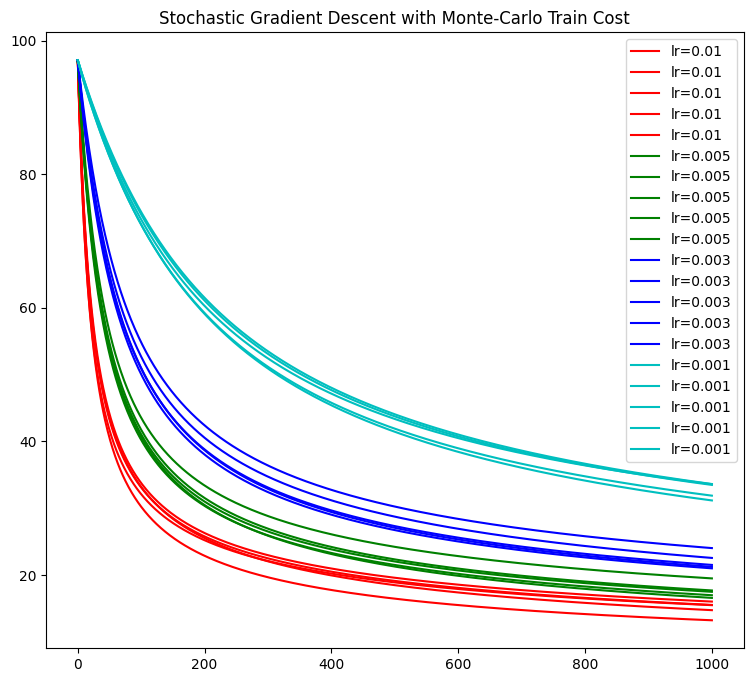

In [32]:
fig = plt.figure(figsize=(9, 8))
for i in range(len(sgd_montc_train_costs)):
    for j in range(len(sgd_montc_train_costs[i])):
        plt.plot(sgd_montc_train_costs[i][j], label=f'lr={lrs[i]}', color=colors[i])
plt.legend()
plt.title('Stochastic Gradient Descent with Monte-Carlo Train Cost')
plt.show()
fig.savefig('plots/sgd_montc.png')

In [33]:
kfold_cv = crossValdAC.CrossVald(option='k_fold', k_fold=6)
gd_kfold_train_costs, gd_kfold_opt_model = kfold_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5)

Implementing K-Fold Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  35.041
Iteration   200 | Cost:  27.427
Iteration   300 | Cost:  24.007
Iteration   400 | Cost:  21.929
Iteration   500 | Cost:  20.482
Iteration   600 | Cost:  19.393
Iteration   700 | Cost:  18.532
Iteration   800 | Cost:  17.826
Iteration   900 | Cost:  17.233
Iteration  1000 | Cost:  16.723
F1-score: 0.972972972972973
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  37.186
Iteration   200 | Cost:  28.852
Iteration   300 | Cost:  25.103
Iteration   400 | Cost:  22.836
Iteration   500 | Cost:  21.268
Iteration   600 | Cost:  20.095
Iteration   700 | Cost:  19.172
Iteration   800 | Cost:  18.420
Iteration   900 | Cost:  17.791
Iteration  1000 | Cost:  17.254
F1-score: 1.0
----------------- lr : 0.01 -----------------
Im

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration   900 | Cost:  15.473
Iteration  1000 | Cost:  14.945
F1-score: 0.918918918918919
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  33.216
Iteration   200 | Cost:  25.161
Iteration   300 | Cost:  21.626
Iteration   400 | Cost:  19.520
Iteration   500 | Cost:  18.078
Iteration   600 | Cost:  17.010
Iteration   700 | Cost:  16.175
Iteration   800 | Cost:  15.499
Iteration   900 | Cost:  14.936
Iteration  1000 | Cost:  14.458
F1-score: 0.896551724137931
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  114.369
Iteration   100 | Cost:  35.661
Iteration   200 | Cost:  27.979
Iteration   300 | Cost:  24.560
Iteration   400 | Cost:  22.497
Iteration   500 | Cost:  21.068
Iteration   600 | Cost:  19.996
Iteration   700 | Cost:  19.150
Iteration   800 | Cost:  18.459
Iteration   900 | Cost:  17.879
Iteration  1000 | Cost:  17.382
F1-score

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration   700 | Cost:  23.509
Iteration   800 | Cost:  22.560
Iteration   900 | Cost:  21.769
Iteration  1000 | Cost:  21.097
F1-score: 0.9714285714285714
----------------- lr : 0.005 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  46.815
Iteration   200 | Cost:  35.550
Iteration   300 | Cost:  30.485
Iteration   400 | Cost:  27.450
Iteration   500 | Cost:  25.365
Iteration   600 | Cost:  23.815
Iteration   700 | Cost:  22.602
Iteration   800 | Cost:  21.616
Iteration   900 | Cost:  20.793
Iteration  1000 | Cost:  20.091
F1-score: 0.9444444444444444
----------------- lr : 0.005 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  46.416
Iteration   200 | Cost:  35.400
Iteration   300 | Cost:  30.455
Iteration   400 | Cost:  27.491
Iteration   500 | Cost:  25.453
Iteration   600 | Cost:  23.935
Iteration   700 | Cost:  22.744
Iteration   800 | Cost:  21.774
Iter

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration   600 | Cost:  21.289
Iteration   700 | Cost:  20.143
Iteration   800 | Cost:  19.217
Iteration   900 | Cost:  18.448
Iteration  1000 | Cost:  17.795
F1-score: 0.9500000000000001
----------------- lr : 0.003 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  56.983
Iteration   200 | Cost:  42.984
Iteration   300 | Cost:  36.525
Iteration   400 | Cost:  32.673
Iteration   500 | Cost:  30.053
Iteration   600 | Cost:  28.124
Iteration   700 | Cost:  26.626
Iteration   800 | Cost:  25.418
Iteration   900 | Cost:  24.416
Iteration  1000 | Cost:  23.566
F1-score: 0.9142857142857143
----------------- lr : 0.003 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  55.998
Iteration   200 | Cost:  42.340
Iteration   300 | Cost:  36.031
Iteration   400 | Cost:  32.250
Iteration   500 | Cost:  29.669
Iteration   600 | Cost:  27.762
Iteration   700 | Cost:  26.277
Iter

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration   400 | Cost:  33.012
Iteration   500 | Cost:  30.336
Iteration   600 | Cost:  28.358
Iteration   700 | Cost:  26.818
Iteration   800 | Cost:  25.574
Iteration   900 | Cost:  24.539
Iteration  1000 | Cost:  23.661
F1-score: 0.9777777777777777
----------------- lr : 0.003 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  57.646
Iteration   200 | Cost:  43.992
Iteration   300 | Cost:  37.617
Iteration   400 | Cost:  33.774
Iteration   500 | Cost:  31.137
Iteration   600 | Cost:  29.183
Iteration   700 | Cost:  27.657
Iteration   800 | Cost:  26.421
Iteration   900 | Cost:  25.392
Iteration  1000 | Cost:  24.518
F1-score: 0.972972972972973
----------------- lr : 0.003 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  114.369
Iteration   100 | Cost:  57.816
Iteration   200 | Cost:  44.247
Iteration   300 | Cost:  37.877
Iteration   400 | Cost:  34.022
Iteration   500 | Cost:  31.369
Itera

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration   100 | Cost:  84.059
Iteration   200 | Cost:  67.950
Iteration   300 | Cost:  58.471
Iteration   400 | Cost:  52.222
Iteration   500 | Cost:  47.764
Iteration   600 | Cost:  44.399
Iteration   700 | Cost:  41.753
Iteration   800 | Cost:  39.605
Iteration   900 | Cost:  37.819
Iteration  1000 | Cost:  36.304
F1-score: 0.967741935483871
----------------- lr : 0.001 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  81.512
Iteration   200 | Cost:  64.857
Iteration   300 | Cost:  55.295
Iteration   400 | Cost:  49.087
Iteration   500 | Cost:  44.703
Iteration   600 | Cost:  41.421
Iteration   700 | Cost:  38.857
Iteration   800 | Cost:  36.786
Iteration   900 | Cost:  35.073
Iteration  1000 | Cost:  33.625
F1-score: 0.962962962962963
----------------- lr : 0.001 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  83.248
Iteration   200 | Cost:  67.095
Iterat

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration  1000 | Cost:  36.323
F1-score: 0.9767441860465117
----------------- lr : 0.001 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  114.369
Iteration   100 | Cost:  82.929
Iteration   200 | Cost:  67.242
Iteration   300 | Cost:  58.046
Iteration   400 | Cost:  52.000
Iteration   500 | Cost:  47.695
Iteration   600 | Cost:  44.451
Iteration   700 | Cost:  41.903
Iteration   800 | Cost:  39.836
Iteration   900 | Cost:  38.119
Iteration  1000 | Cost:  36.663
F1-score: 1.0


In [34]:
print(gd_kfold_opt_model)

{'f1': 0.9624939874939874, 'lr': 0.005, 'w': array([[  0.92126727],
       [-11.96549896],
       [  9.28182981]])}


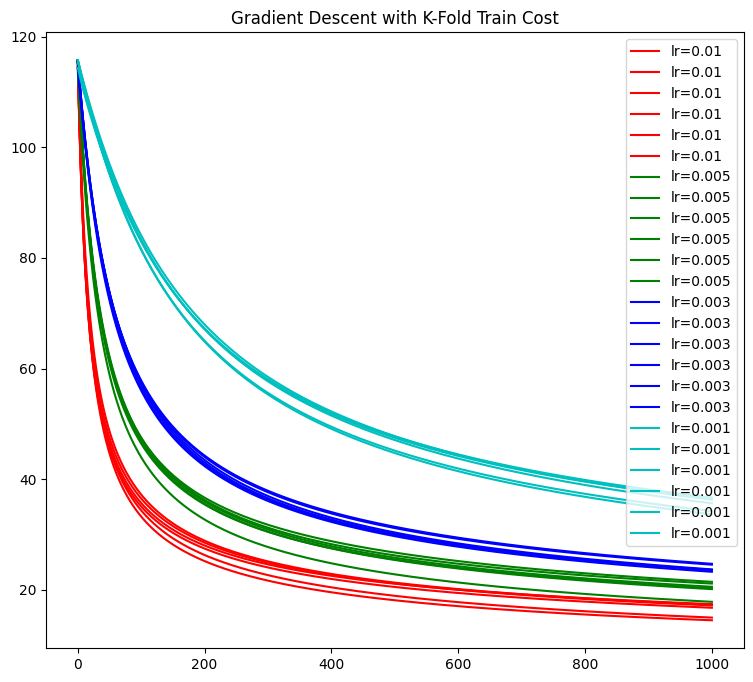

In [35]:
fig = plt.figure(figsize=(9, 8))
for i in range(len(gd_kfold_train_costs)):
    for j in range(len(gd_kfold_train_costs[i])):
        plt.plot(gd_kfold_train_costs[i][j], label=f'lr={lrs[i]}', color=colors[i])
plt.legend()
plt.title('Gradient Descent with K-Fold Train Cost')
plt.show()
fig.savefig('plots/gd_kfold.png')

In [36]:
sgd_kfold_train_costs, sgd_kfold_opt_model = kfold_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5, stochGD=True)

Implementing K-Fold Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  37.036
Iteration   200 | Cost:  28.878


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  25.231
Iteration   400 | Cost:  23.028
Iteration   500 | Cost:  21.502
Iteration   600 | Cost:  20.360
Iteration   700 | Cost:  19.460
Iteration   800 | Cost:  18.726
Iteration   900 | Cost:  18.112
Iteration  1000 | Cost:  17.586
F1-score: 1.0
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  37.492


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  29.261
Iteration   300 | Cost:  25.574
Iteration   400 | Cost:  23.339
Iteration   500 | Cost:  21.787
Iteration   600 | Cost:  20.621
Iteration   700 | Cost:  19.701
Iteration   800 | Cost:  18.948
Iteration   900 | Cost:  18.316
Iteration  1000 | Cost:  17.775
F1-score: 1.0
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  31.088
Iteration   200 | Cost:  23.113
Iteration   300 | Cost:  19.577
Iteration   400 | Cost:  17.462
Iteration   500 | Cost:  16.012
Iteration   600 | Cost:  14.937
Iteration   700 | Cost:  14.098
Iteration   800 | Cost:  13.419
Iteration   900 | Cost:  12.855
Iteration  1000 | Cost:  12.377
F1-score: 0.8823529411764706
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  35.444
Iteration   200 | Cost:  27.665


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  24.180
Iteration   400 | Cost:  22.067
Iteration   500 | Cost:  20.597
Iteration   600 | Cost:  19.493
Iteration   700 | Cost:  18.619
Iteration   800 | Cost:  17.904
Iteration   900 | Cost:  17.303
Iteration  1000 | Cost:  16.788
F1-score: 1.0
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  35.983


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  27.815
Iteration   300 | Cost:  24.140
Iteration   400 | Cost:  21.911
Iteration   500 | Cost:  20.363
Iteration   600 | Cost:  19.203
Iteration   700 | Cost:  18.288
Iteration   800 | Cost:  17.540
Iteration   900 | Cost:  16.913
Iteration  1000 | Cost:  16.377
F1-score: 0.9375
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  114.369


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  35.569
Iteration   200 | Cost:  27.848
Iteration   300 | Cost:  24.393
Iteration   400 | Cost:  22.300
Iteration   500 | Cost:  20.846
Iteration   600 | Cost:  19.755
Iteration   700 | Cost:  18.894
Iteration   800 | Cost:  18.190
Iteration   900 | Cost:  17.600
Iteration  1000 | Cost:  17.094
F1-score: 1.0
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  46.012
Iteration   200 | Cost:  34.893


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  29.964
Iteration   400 | Cost:  27.029
Iteration   500 | Cost:  25.018
Iteration   600 | Cost:  23.523
Iteration   700 | Cost:  22.351
Iteration   800 | Cost:  21.397
Iteration   900 | Cost:  20.599
Iteration  1000 | Cost:  19.917
F1-score: 1.0
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  45.970


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  35.056
Iteration   300 | Cost:  30.212
Iteration   400 | Cost:  27.325
Iteration   500 | Cost:  25.345
Iteration   600 | Cost:  23.873
Iteration   700 | Cost:  22.719
Iteration   800 | Cost:  21.780
Iteration   900 | Cost:  20.995
Iteration  1000 | Cost:  20.325
F1-score: 1.0
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  45.414
Iteration   200 | Cost:  34.357
Iteration   300 | Cost:  29.394
Iteration   400 | Cost:  26.423
Iteration   500 | Cost:  24.386
Iteration   600 | Cost:  22.875
Iteration   700 | Cost:  21.694
Iteration   800 | Cost:  20.736
Iteration   900 | Cost:  19.938
Iteration  1000 | Cost:  19.259
F1-score: 0.9268292682926829
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  47.182
Iteration   200 | Cost:  35.922


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  30.851
Iteration   400 | Cost:  27.811
Iteration   500 | Cost:  25.723
Iteration   600 | Cost:  24.169
Iteration   700 | Cost:  22.952
Iteration   800 | Cost:  21.963
Iteration   900 | Cost:  21.137
Iteration  1000 | Cost:  20.433
F1-score: 0.972972972972973
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  48.910


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  37.469
Iteration   300 | Cost:  32.272
Iteration   400 | Cost:  29.146
Iteration   500 | Cost:  26.994
Iteration   600 | Cost:  25.393
Iteration   700 | Cost:  24.137
Iteration   800 | Cost:  23.115
Iteration   900 | Cost:  22.261
Iteration  1000 | Cost:  21.533
F1-score: 1.0
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  114.369


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  46.571
Iteration   200 | Cost:  35.252
Iteration   300 | Cost:  30.177
Iteration   400 | Cost:  27.149
Iteration   500 | Cost:  25.080
Iteration   600 | Cost:  23.550
Iteration   700 | Cost:  22.358
Iteration   800 | Cost:  21.394
Iteration   900 | Cost:  20.594
Iteration  1000 | Cost:  19.914
F1-score: 0.9333333333333333
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  56.688
Iteration   200 | Cost:  43.174


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  36.937
Iteration   400 | Cost:  33.205
Iteration   500 | Cost:  30.660
Iteration   600 | Cost:  28.782
Iteration   700 | Cost:  27.322
Iteration   800 | Cost:  26.143
Iteration   900 | Cost:  25.164
Iteration  1000 | Cost:  24.334
F1-score: 1.0
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  59.859


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  45.880
Iteration   300 | Cost:  39.307
Iteration   400 | Cost:  35.339
Iteration   500 | Cost:  32.614
Iteration   600 | Cost:  30.592
Iteration   700 | Cost:  29.011
Iteration   800 | Cost:  27.729
Iteration   900 | Cost:  26.660
Iteration  1000 | Cost:  25.750
F1-score: 0.9473684210526315
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  57.209
Iteration   200 | Cost:  43.705
Iteration   300 | Cost:  37.515
Iteration   400 | Cost:  33.827
Iteration   500 | Cost:  31.316
Iteration   600 | Cost:  29.464
Iteration   700 | Cost:  28.023
Iteration   800 | Cost:  26.858
Iteration   900 | Cost:  25.890
Iteration  1000 | Cost:  25.067
F1-score: 1.0
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  56.997
Iteration   200 | Cost:  42.849


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  36.284
Iteration   400 | Cost:  32.363
Iteration   500 | Cost:  29.697
Iteration   600 | Cost:  27.736
Iteration   700 | Cost:  26.216
Iteration   800 | Cost:  24.993
Iteration   900 | Cost:  23.980
Iteration  1000 | Cost:  23.123
F1-score: 0.9032258064516129
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  56.178


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  42.075
Iteration   300 | Cost:  35.507
Iteration   400 | Cost:  31.557
Iteration   500 | Cost:  28.853
Iteration   600 | Cost:  26.850
Iteration   700 | Cost:  25.289
Iteration   800 | Cost:  24.026
Iteration   900 | Cost:  22.976
Iteration  1000 | Cost:  22.084
F1-score: 0.896551724137931
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  114.369


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  56.324
Iteration   200 | Cost:  42.551
Iteration   300 | Cost:  36.117
Iteration   400 | Cost:  32.232
Iteration   500 | Cost:  29.564
Iteration   600 | Cost:  27.584
Iteration   700 | Cost:  26.037
Iteration   800 | Cost:  24.785
Iteration   900 | Cost:  23.743
Iteration  1000 | Cost:  22.857
F1-score: 0.9743589743589743
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  82.370
Iteration   200 | Cost:  66.043


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  56.593
Iteration   400 | Cost:  50.412
Iteration   500 | Cost:  46.017
Iteration   600 | Cost:  42.706
Iteration   700 | Cost:  40.104
Iteration   800 | Cost:  37.993
Iteration   900 | Cost:  36.238
Iteration  1000 | Cost:  34.749
F1-score: 0.975609756097561
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  81.246


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  64.618
Iteration   300 | Cost:  55.100
Iteration   400 | Cost:  48.921
Iteration   500 | Cost:  44.555
Iteration   600 | Cost:  41.282
Iteration   700 | Cost:  38.720
Iteration   800 | Cost:  36.650
Iteration   900 | Cost:  34.935
Iteration  1000 | Cost:  33.485
F1-score: 0.972972972972973
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  82.125
Iteration   200 | Cost:  65.619
Iteration   300 | Cost:  56.060
Iteration   400 | Cost:  49.819
Iteration   500 | Cost:  45.395
Iteration   600 | Cost:  42.071
Iteration   700 | Cost:  39.466
Iteration   800 | Cost:  37.357
Iteration   900 | Cost:  35.608
Iteration  1000 | Cost:  34.128
F1-score: 0.9268292682926829
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  83.072
Iteration   200 | Cost:  66.936


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  57.594
Iteration   400 | Cost:  51.492
Iteration   500 | Cost:  47.163
Iteration   600 | Cost:  43.908
Iteration   700 | Cost:  41.354
Iteration   800 | Cost:  39.284
Iteration   900 | Cost:  37.566
Iteration  1000 | Cost:  36.109
F1-score: 0.9655172413793104
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  84.056


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  68.030
Iteration   300 | Cost:  58.628
Iteration   400 | Cost:  52.441
Iteration   500 | Cost:  48.030
Iteration   600 | Cost:  44.703
Iteration   700 | Cost:  42.088
Iteration   800 | Cost:  39.966
Iteration   900 | Cost:  38.202
Iteration  1000 | Cost:  36.707
F1-score: 0.9696969696969697
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  114.369


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  83.831
Iteration   200 | Cost:  68.329
Iteration   300 | Cost:  59.191
Iteration   400 | Cost:  53.165
Iteration   500 | Cost:  48.864
Iteration   600 | Cost:  45.617
Iteration   700 | Cost:  43.062
Iteration   800 | Cost:  40.987
Iteration   900 | Cost:  39.259
Iteration  1000 | Cost:  37.792
F1-score: 0.9600000000000001


In [37]:
print(sgd_kfold_opt_model)

{'f1': 0.9721892624331648, 'lr': 0.005, 'w': array([[  1.03532488],
       [-11.97069673],
       [  9.29237871]])}


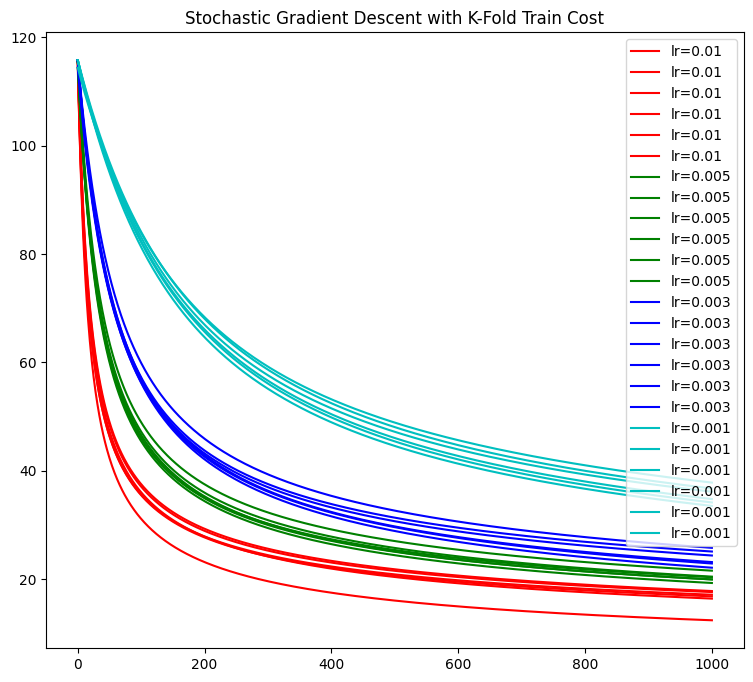

In [38]:
fig = plt.figure(figsize=(9, 8))
for i in range(len(sgd_kfold_train_costs)):
    for j in range(len(sgd_kfold_train_costs[i])):
        plt.plot(sgd_kfold_train_costs[i][j], label=f'lr={lrs[i]}', color=colors[i])
plt.legend()
plt.title('Stochastic Gradient Descent with K-Fold Train Cost')
plt.show()
fig.savefig('plots/sgd_kfold.png')

## Batch Gradient Descent

In [39]:
logReg1 = logRegAC.LogReg(lr=0.01, max_iter=1000)
logReg1.fit(train_x, train_y, iter_step=100)
pred = logReg1.predict(test_x)
print('F1 Score: ', utilsAC.get_performance_measure(test_y, pred)['f1'])

Implementing Batch Gradient Descent.
Iteration     0 | Cost:  110.904
Iteration   100 | Cost:  32.109
Iteration   200 | Cost:  24.199
Iteration   300 | Cost:  20.670
Iteration   400 | Cost:  18.549
Iteration   500 | Cost:  17.087
Iteration   600 | Cost:  15.998
Iteration   700 | Cost:  15.143
Iteration   800 | Cost:  14.449
Iteration   900 | Cost:  13.870
Iteration  1000 | Cost:  13.376
F1 Score:  0.8275862068965517


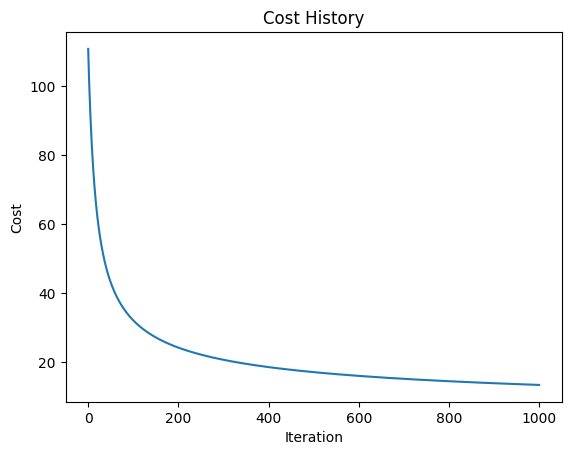

In [40]:
fig = plt.figure()
plt.plot(logReg1.get_cost_hist())
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost History')
plt.show()
fig.savefig('plots/gd_cost_hist.png')

In [41]:
gd_trained_weights = logReg1.get_params()
print(f'Trained Weights: {gd_trained_weights}')
gd_cf_info = utilsAC.get_performance_measure(data_y, logReg1.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
gd_cf_matrix = [[gd_cf_info['tn'], gd_cf_info['fn']], [gd_cf_info['fp'], gd_cf_info['tp']]]

Trained Weights: [[  1.31075687]
 [-15.20504609]
 [ 11.90564837]]


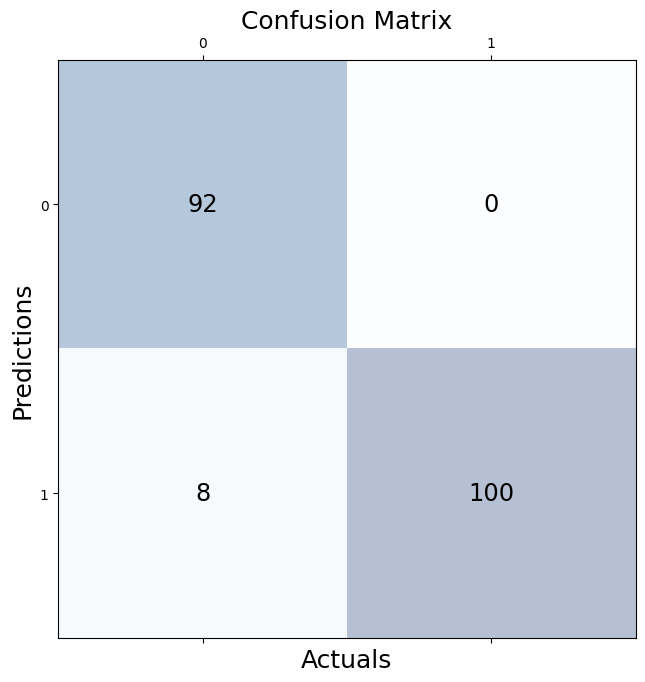

In [42]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(gd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(gd_cf_matrix)):
    for j in range(len(gd_cf_matrix[i])):
        ax.text(x=j, y=i,s=gd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/gd_confusion_matrix.png')

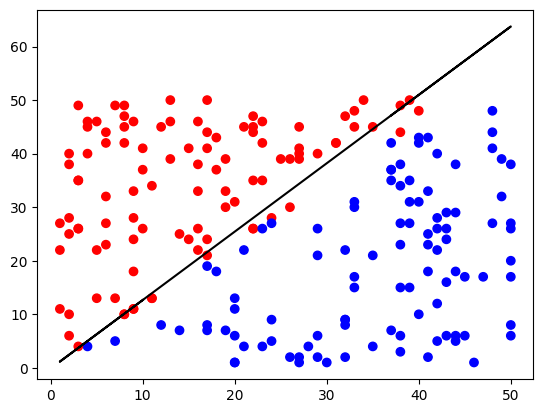

In [43]:
gd_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], gd_trained_weights).flatten()
gd_plot_y = []
for i in range(len(gd_vals)):
    gd_plot_y.append(-(gd_trained_weights[0] + (gd_trained_weights[1] * data_x.iloc[i, 0])) / gd_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], gd_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/gd_data_dist_db.png')

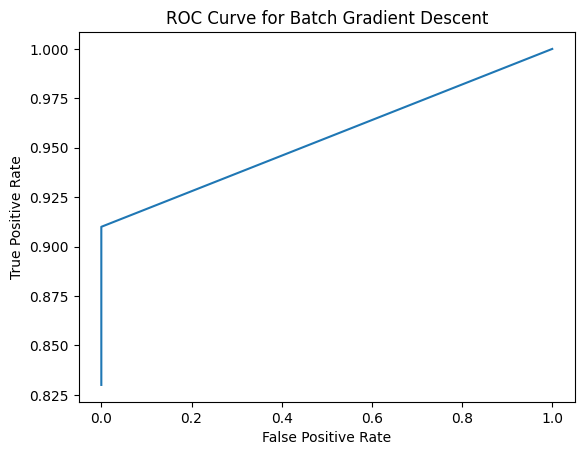

In [44]:
gd_pred_prob = logReg1.predict(data_x, prob=True)
gd_tpr = []
gd_fpr = []
for t in thresh:
    gd_pred = [1 if i >= t else 0 for i in gd_pred_prob]
    gd_cf_info = utilsAC.get_performance_measure(data_y, gd_pred)
    tp = gd_cf_info['tp']
    fp = gd_cf_info['fp']
    tn = gd_cf_info['tn']
    fn = gd_cf_info['fn']
    gd_tpr.append(tp/(tp+fn))
    gd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(gd_fpr, gd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Batch Gradient Descent')
plt.show()
fig.savefig('plots/gd_roc.png')

## Stochastic Gradient Descent

In [45]:
logReg2 = logRegAC.LogReg(lr=0.01, max_iter=1000, stochGD=True)
logReg2.fit(train_x, train_y, iter_step=100)
pred2 = logReg2.predict(test_x)
print('F1 Score: ', utilsAC.get_performance_measure(test_y, pred2)['f1'])

Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  110.904
Iteration   100 | Cost:  32.223
Iteration   200 | Cost:  24.252
Iteration   300 | Cost:  20.705
Iteration   400 | Cost:  18.574
Iteration   500 | Cost:  17.107
Iteration   600 | Cost:  16.014
Iteration   700 | Cost:  15.158
Iteration   800 | Cost:  14.462
Iteration   900 | Cost:  13.881
Iteration  1000 | Cost:  13.386
F1 Score:  0.8275862068965517


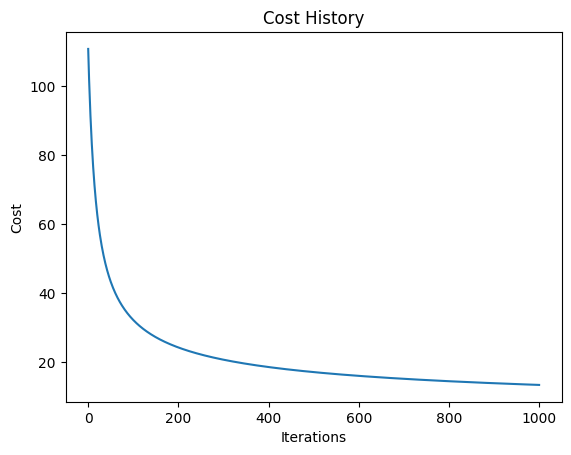

In [46]:
fig = plt.figure()
plt.plot(logReg2.get_cost_hist())
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost History')
plt.show()
fig.savefig('plots/sgd_cost_hist.png')

In [47]:
sgd_trained_weights = logReg2.get_params()
print(f'Trained Weights: {sgd_trained_weights}')
sgd_cf_info = utilsAC.get_performance_measure(data_y, logReg2.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
sgd_cf_matrix = [[sgd_cf_info['tn'], sgd_cf_info['fn']], [sgd_cf_info['fp'], sgd_cf_info['tp']]]

Trained Weights: [[  1.29754443]
 [-15.19897439]
 [ 11.89283299]]


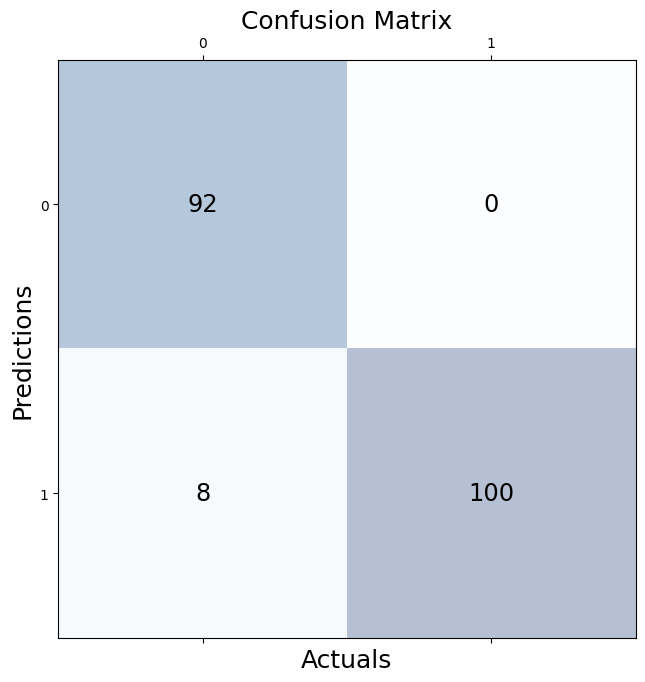

In [48]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(sgd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(sgd_cf_matrix)):
    for j in range(len(sgd_cf_matrix[i])):
        ax.text(x=j, y=i,s=sgd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/sgd_confusion_matrix.png')

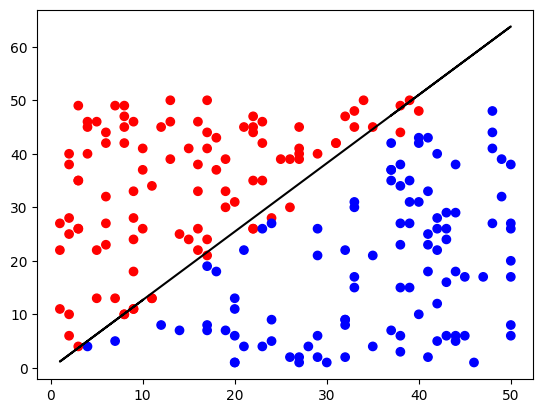

In [49]:
sgd_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], sgd_trained_weights).flatten()
sgd_plot_y = []
for i in range(len(sgd_vals)):
    sgd_plot_y.append(-(sgd_trained_weights[0] + (sgd_trained_weights[1] * data_x.iloc[i, 0])) / sgd_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], sgd_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/sgd_data_dist_db.png')

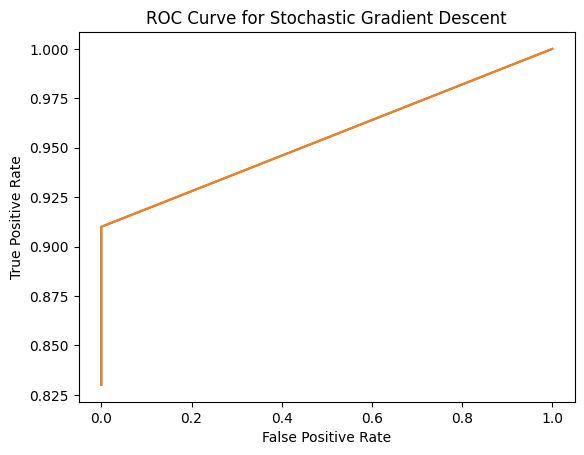

In [50]:
sgd_pred_prob = logReg2.predict(data_x, prob=True)
sgd_tpr = []
sgd_fpr = []
for t in thresh:
    sgd_pred = [1 if i >= t else 0 for i in sgd_pred_prob]
    sgd_cf_info = utilsAC.get_performance_measure(data_y, sgd_pred)
    tp = sgd_cf_info['tp']
    fp = sgd_cf_info['fp']
    tn = sgd_cf_info['tn']
    fn = sgd_cf_info['fn']
    sgd_tpr.append(tp/(tp+fn))
    sgd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(sgd_fpr, sgd_tpr)
plt.plot(gd_fpr, gd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Stochastic Gradient Descent')
plt.show()
fig.savefig('plots/sgd_roc.png')